# Problem 2
- Multiple terminal Routing

## [0] Import
-------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import heapq
import time
import copy
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

### 파일 경로지정
my_PATH = "/content/drive/MyDrive/School/종합설계_2팀/Code"
os.chdir(my_PATH)
!dir

Mounted at /content/drive
2_TRPO_Rand.ipynb			    PROBLEM1.ipynb
Actor\ Critic				    Problem2\ ver.1.ipynb
circuit_routing_with_A__algorithm(2).ipynb  Problem2\ ver.2.ipynb
configs.yaml				    TRPO
ddqn					    TRPO_Rand.ipynb
DQN					    TRPO_Routing.ipynb
Final_code				    TRPO_Routing_YOUNGHWAN_ver1.ipynb
models					    WorldModels\ ver.1\ (YoungHwan).ipynb


## [1] Hyperparameters
------------

In [ ]:
# Hyperparameters
GAMMA = 0.9
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 150000
TARGET_UPDATE = 50
BATCH_SIZE = 32
LR = 0.001
MEMORY_SIZE = 100000

criterion = nn.MSELoss()

## [2] Make Environment
----

Pairs: [((12, 0), (11, 9)), ((0, 2), (2, 1)), ((14, 2), (6, 11))]
Obstacles: [(2, 2), (2, 3), (3, 2), (3, 3), (9, 6), (9, 7), (10, 6), (10, 7)]


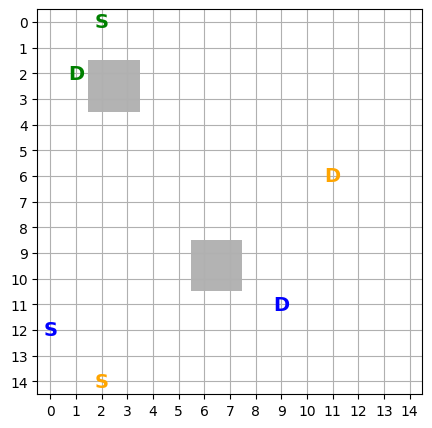

In [ ]:
# Environment configuration
GRID_WIDTH = 15
GRID_HEIGHT = 15
GRID_SIZE = (GRID_HEIGHT, GRID_WIDTH)
ACTIONS = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Right, Left, Down, Up
# [(Start point, Endpoint), (Start point 2, Endpoint 2), ... ]
global PAIRS
global OBSTACLES
PAIRS = [((12, 0), (11, 9)), ((0, 2), (2, 1)), ((14, 2), (6, 11))]
OBSTACLES = [(2, 2), (2, 3), (3, 2), (3, 3), (9, 6), (9, 7), (10, 6), (10, 7)]



"""
PAIRS = [((12, 0), (11, 9)), ((0, 2), (2, 1)), ((14, 2), (6, 11))]
OBSTACLES = [(2, 2), (2, 3), (3, 2), (3, 3), (9, 6), (9, 7), (10, 6), (10, 7)]

PAIRS = [((1, 9), (11, 7)), ((2, 2), (10, 0)), ((7, 12), (14, 1))]
OBSTACLES = [(4, 10), (4, 11), (5, 10), (5, 11), (9, 2), (9, 3), (10, 2), (10, 3)]

PAIRS = [((2, 4), (9, 0)), ((4, 6), (11, 7)), ((1, 11), (7, 13)), ((6, 9), (12, 11))]
OBSTACLES = [(7, 11), (7, 12), (8, 11), (8, 12), (6, 4), (6, 5), (7, 4), (7, 5)]

"""

grid = np.zeros(GRID_SIZE, dtype=int)

def generate_obstacles(grid,obstacles):
    for i in range(GRID_HEIGHT):
      for j in range(GRID_WIDTH):
        for obstacle in OBSTACLES:
          if (i,j) == obstacle:
            grid[i][j] = 1

    # chip_positions = set()

    # # # 2x2 칩 2개 생성
    # for _ in range(2):
    #     x, y = random.randint(0, GRID_WIDTH - 2), random.randint(0, GRID_HEIGHT - 2)
    #     while any((x + i, y + j) in chip_positions or grid[x + i][y + j] == 1 for i in range(2) for j in range(2)):
    #         x, y = random.randint(0, GRID_WIDTH - 2), random.randint(0, GRID_HEIGHT - 2)
    #     for i in range(2):
    #         for j in range(2):
    #             chip_positions.add((x + i, y + j))
    #             grid[x + i][y + j] = 1
    #             obstacles.append((x+i,y+j))

    # # 1/100 확률로 scatter object 생성
    # for _ in range(100):
    #     x, y = random.randint(0, GRID_WIDTH - 1), random.randint(0, GRID_HEIGHT - 1)
    #     if random.random() < 1/60 and (x, y) not in chip_positions:
    #         grid[x][y] = 1
    #         obstacles.append((x,y))

def generate_pairs(grid, pairs):
    for i in range(3):
        # 랜덤 시작 지점 생성
        start = (random.randint(0, GRID_HEIGHT - 1), random.randint(0, GRID_WIDTH - 1))

        # 랜덤 종료 지점 생성
        end = (random.randint(0, GRID_HEIGHT - 1), random.randint(0, GRID_WIDTH - 1))

        # 시작점과 종료점이 겹치지 않도록 확인
        while start == end or (start, end) in pairs or grid[start[0]][start[1]] == 1 or grid[end[0]][end[1]] == 1:
            start = (random.randint(0, GRID_HEIGHT - 1), random.randint(0, GRID_WIDTH - 1))
            end = (random.randint(0, GRID_HEIGHT - 1), random.randint(0, GRID_WIDTH - 1))

        # 시작점과 종료점 쌍을 리스트에 추가
        pairs.append((start, end))


"""
영환 코드 추가
A* 알고리즘으로 Routing 경로 추가
Start point, End point Grid로 출력
"""
# A* algorithm implementation
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search(grid, start, goal):
    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    while frontier:
        _, current = heapq.heappop(frontier)

        if current == goal:
            break

        for dx, dy in ACTIONS:
            next = (current[0] + dx, current[1] + dy)
            if 0 <= next[0] < GRID_HEIGHT and 0 <= next[1] < GRID_WIDTH and grid[next[0]][next[1]] != 1:
                new_cost = cost_so_far[current] + 1
                if next not in cost_so_far or new_cost < cost_so_far[next]:
                    cost_so_far[next] = new_cost
                    priority = new_cost + heuristic(goal, next)
                    heapq.heappush(frontier, (priority, next))
                    came_from[next] = current
    return came_from

def reconstruct_path(came_from, start, goal):
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path

def plot_grid(grid, pairs, obstacles, paths):
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap='Greys', alpha=0.3)

    # Different colors for each pair
    colors = ['blue', 'green', 'orange', 'yellow']

    for idx, (start, end) in enumerate(pairs):
        # Start point with label 'S'
        plt.text(start[1], start[0], 'S', color=colors[idx], ha='center', va='center', fontsize=14, weight='bold')
        # End point with label 'D'
        plt.text(end[1], end[0], 'D', color=colors[idx], ha='center', va='center', fontsize=14, weight='bold')
        # Plotting paths
        path_x, path_y = zip(*[(y, x) for x, y in paths[idx]])  # Swapping x and y for correct plotting
        plt.plot(path_x, path_y,color=colors[idx], linewidth=2)

    # Uncomment below to plot obstacles
    # for x, y in obstacles:
    #     plt.scatter(y, x, color='red', marker='s')  # Swapping x and y for correct plotting

    plt.grid(True)
    plt.xticks(range(GRID_WIDTH))
    plt.yticks(range(GRID_HEIGHT))
    plt.show()

generate_obstacles(grid,OBSTACLES)
# generate_pairs(grid, PAIRS)
print('Pairs:',PAIRS)
print('Obstacles:', OBSTACLES)
paths = [reconstruct_path(a_star_search(grid, start, end), start, end) for start, end in PAIRS]
plot_grid(grid, PAIRS, OBSTACLES, paths)


## [2] Environment Setting
---------

In [ ]:
ACTIONS = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Right, Left, Down, Up

# Environment class
class RoutingEnv:
    # Envirionment 초기화
    # 시작위치 = start point
    # GRID = (10x8) size with 0
    def __init__(self, start, destination):
        self.start = start
        self.destination = destination
        self.grid = np.zeros(GRID_SIZE, dtype=int)
        # Start point, End point 1로 초기화, 나머지는 0
        for i in range(len(PAIRS)):
          self.grid[PAIRS[i][0][0]][PAIRS[i][0][1]]= 1
          self.grid[PAIRS[i][1][0]][PAIRS[i][1][1]]= 1
        # 장애물 있는 곳 1로 초기화
        for i in range(len(OBSTACLES)):
          self.grid[OBSTACLES[i][0]][OBSTACLES[i][1]]= 1

    # 시작위치로 초기화
    # Grid 모두 0으로 초기화
    # 시작위치, 종료위치 각각 1, 2로 대입
    def reset(self, solutions):
        self.current_position = self.start
        if len(solutions) == 0:
          self.grid = np.zeros(GRID_SIZE, dtype=int)
        else:
          grid = copy.deepcopy(solutions[-1])
          self.grid = np.zeros(GRID_SIZE, dtype=int)
          self.grid = grid
        for i in range(len(PAIRS)):
          self.grid[PAIRS[i][0][0]][PAIRS[i][0][1]]= 1
          self.grid[PAIRS[i][1][0]][PAIRS[i][1][1]]= 1
        # 장애물 있는 곳 1로 초기화
        for i in range(len(OBSTACLES)):
          self.grid[OBSTACLES[i][0]][OBSTACLES[i][1]]= 1

        self.grid[self.destination[0]][self.destination[1]] = 2

        return self.get_state()

    # 현재 Grid state와 Agent의 position을 담은 Grid를 concat (160차원 벡터)하여 반환
    def get_state(self):
        flat_grid = self.grid.flatten()
        pos = np.zeros(GRID_SIZE, dtype=int)
        pos[self.current_position[0]][self.current_position[1]] = 1
        flat_pos = pos.flatten()
        state = np.concatenate((flat_grid, flat_pos))
        return torch.tensor(state, dtype=torch.float32).to(device)

    # Agent 움직임
    # Return : next state, reward, done
    def step(self, action, solutions):
        dx, dy = ACTIONS[action]
        new_position = (self.current_position[0] + dx, self.current_position[1] + dy)

        # Agent가 Grid 밖으로 탈출할 경우
        if (new_position[0] < 0 or new_position[0] >= GRID_SIZE[0] or
            new_position[1] < 0 or new_position[1] >= GRID_SIZE[1]):

            self.reset(solutions)
            # print("Out of Bound")

            return self.get_state(), -10, False, self.current_position  # Out of bounds

        # 이미 방문한 곳인지 파악 (wire 교차 Check)
        if self.grid[new_position[0]][new_position[1]] == 1:
            # self.grid = np.zeros(GRID_SIZE, dtype=int)
            # self.grid[0][4] = self.grid[0][6] = self.grid[2][2] = self.grid[2][5] = 1
            # self.grid[6][3] =  self.grid[6][5] =  self.grid[8][1] =  self.grid[8][4] = 1
            self.reset(solutions) # 자신의 Routing 경로에 아예 갇혀서 안움직이는 경우가 있어서 Reset해버림. 결과 훨씬 더 좋음
            # print("Already Visited")

            # return self.get_state(), -80, True
            return self.get_state(), -10, False, self.current_position  # Already visited

        # Move to the new position
        self.grid[self.current_position[0]][self.current_position[1]] = 1  # Mark old position as visited
        self.current_position = new_position
        self.grid[new_position[0]][new_position[1]] = 1  # Mark new position as visited

        # 목적지 도착 확인
        if self.current_position == self.destination:
            return self.get_state(), 100, True, self.current_position

        return self.get_state(), -1, False, self.current_position

    def render(self):
        wl_count = 0
        print('-' * 50)
        for i in range(GRID_SIZE[0]):
            for j in range(GRID_SIZE[1]):
                if (i, j) == self.start:
                    print('S', end=' ')
                elif (i, j) == self.destination:
                    print('D', end=' ')
                elif (i, j) == self.current_position:
                    print('A', end=' ')
                elif any((i, j) == pair[0] for pair in PAIRS):
                    print('s', end=' ')
                elif any((i, j) == pair[1] for pair in PAIRS):
                    print('d', end=' ')
                elif (i, j) in OBSTACLES:
                    print('X', end=' ')
                elif self.grid[i][j] == 1:
                    wl_count += 1
                    print('*', end=' ')
                else:
                    print('.', end=' ')
            print()  # New line for next row
        # print('-'*50)
        return wl_count

    def visualize_routing(self, solutions):
        visual_grid = np.zeros(GRID_SIZE, dtype=int)

        plt.figure(figsize=(5, 5))
        colors = ['blue', 'green', 'orange', 'yellow']

        prev_solution = solutions[0]
        for idx in range(1,len(solutions)):
            current_solution = solutions[idx]
            current_path = current_solution - prev_solution
            current_path[PAIRS[idx-1][0][0]][PAIRS[idx-1][0][1]] = 1
            current_path[PAIRS[idx-1][1][0]][PAIRS[idx-1][1][1]] = 1
            prev_solution = np.copy(current_solution)
            y, x = np.where(current_path == 1)
            y = GRID_SIZE[0] - 1 - y  # Flip y-coordinates for matplotlib
            # Plot each segment of the path
            for i in range(len(x) - 1):
                plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color=colors[idx-1], linewidth=2)

        # Plot start and end points
        for idx, (start, end) in enumerate(PAIRS):
            plt.text(start[1], GRID_SIZE[0] - 1 - start[0], 'S', color=colors[idx], ha='center', va='center', fontsize=14, weight='bold')  # Flip y-coordinates
            plt.text(end[1], GRID_SIZE[0] - 1 - end[0], 'D', color=colors[idx], ha='center', va='center', fontsize=14, weight='bold')  # Flip y-coordinates

        for obs in OBSTACLES:
            # Adjust coordinates to create a half-grid-size box
            obs_x = obs[1] - 0.5
            obs_y = GRID_SIZE[0] - 1 - obs[0] - 0.5
            plt.gca().add_patch(plt.Rectangle((obs_x, obs_y), 1, 1, color='grey', zorder =3 ))

        # Finalize plot
        plt.grid(True)
        plt.xticks(range(GRID_SIZE[1]))
        plt.yticks(range(GRID_SIZE[0]))
        # plt.gca().invert_yaxis()  # Invert y-axis to match the typical coordinate system
        plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_routing_2(positions, pairs):
    plt.figure(figsize=(5, 5))

    # Create grid
    x = np.arange(16)
    y = np.arange(16)
    plt.xticks(x)
    plt.yticks(y)
    plt.grid(True)
    plt.xlim(-1, 16)
    plt.ylim(-1, 16)

    colors = ['blue', 'green', 'orange']
    for idx, pos_list in enumerate(positions):
        for i in range(len(pos_list)-1):
            y1, x1 = pos_list[i]  # Swapping x and y
            y2, x2 = pos_list[i + 1]  # Swapping x and y
            plt.plot([x1, x2], [y1, y2], color=colors[idx], marker='.', zorder=3)

    # Start and end points
    for idx, (start, end) in enumerate(pairs):
        startY, startX = start  # Swapping x and y
        endY, endX = end  # Swapping x and y
        plt.text(startX, startY, 'S', color=colors[idx], ha='center', va='center', fontsize=14, weight='bold')
        plt.text(endX, endY, 'D', color=colors[idx], ha='center', va='center', fontsize=14, weight='bold')

    # Obstacles
    for obs in OBSTACLES:
        obsY, obsX = obs  # Swapping x and y
        obs_x = obsX - 0.5
        obs_y = obsY - 0.5
        plt.gca().add_patch(plt.Rectangle((obs_x, obs_y), 1, 1, color='grey', zorder=3))

    # Invert the y-axis if the grid starts from the top left
    plt.gca().invert_yaxis()

    plt.title('Routing Paths for Pin Pairs')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()



## [3] Network model
----------

In [ ]:

# Define the Q-network
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(GRID_SIZE[0] * GRID_SIZE[1] * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        # self.fc4 = nn.Linear(32, 16)
        # self.fc5 = nn.Linear(16, len(ACTIONS))

        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        # nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        # nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        # x = torch.relu(self.fc4(x))
        # x = self.fc5(x)
        return x



In [ ]:
from torchsummary import summary
model = DQN()
model = model.to(device)
summary(model, (450,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          57,728
            Linear-2                   [-1, 64]           8,256
            Linear-3                    [-1, 4]             260
Total params: 66,244
Trainable params: 66,244
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.25
Estimated Total Size (MB): 0.26
----------------------------------------------------------------


## [4] Replay Memory
-----------

In [ ]:
# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## [5] Optimization
--------

In [ ]:
# Utility functions
def select_action(state, policy_net, steps_done):
    single_state = len(state.shape) == 1
    if single_state:
        state = state.unsqueeze(0)
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    if (steps_done+3000)%3000 == 0:
      print(f"Eps threshold: {eps_threshold} \t Steps: {steps_done}")
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(len(ACTIONS))]], dtype=torch.int64).to(device)

def optimize_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = list(zip(*transitions))

    state_batch = torch.stack(batch[0])
    action_batch = torch.cat(batch[1])
    reward_batch = torch.tensor(batch[2], dtype=torch.float32)
    reward_batch = reward_batch.to(device)
    # reward_batch = torch.cat(batch[2])

    # print(state_batch.size())  #[128,160]
    # print(action_batch.size()) # [128]
    action_batch = action_batch.view(-1, 1)
    # print(action_batch.size()) # [128,1]

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # print(state_action_values.size()) # [128,1]

    next_state_values = target_net(state_batch).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute the Huber loss
    # Loss Function
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return state_action_values.detach().cpu().numpy()

## [*] Model Save
--------

In [ ]:
def save_model_info(model,reward_list, step_list, model_name="ver_2"):

    if not os.path.isdir("./models"):
        os.makedirs("./models")
    # 모델 정보 저장
    torch.save({'model_state_dict': model.state_dict(),
                'rewards': reward_list,
                'steps': step_list
                }, f"./models/model_{model_name}.pth")
    print(f"model_saved : model_{model_name}")


## [6] Training
--------

In [ ]:

# Main training loop
if __name__ == "__main__":
    # policy_net, _, _ = load_model_info(model_name="ver_1")
    # target_net, _, _ = load_model_info(model_name="ver_1")
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    policy_net.train()
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayMemory(MEMORY_SIZE)

    steps_done = 0
    wire_length = 0
    rewards = []
    avg_steps = []
    solutions = []
    answer = []
    best_reward = -500

    max_q = []

    start_time = time.time()
    for episode in range(3000):
        total_reward = 0

        env = RoutingEnv(PAIRS[0][0], PAIRS[0][1])
        solutions = []
        q_value = []
        positions = [[],[],[]]
        state = env.reset(solutions)

        for idx, pair in enumerate(PAIRS):
            solutions.append(env.grid)
            # answer.append(env.grid)

            env = RoutingEnv(pair[0], pair[1])
            state = env.reset(solutions)

            # print("START GRID")
            # env.render()
            done = False

            step_check = 0
            while not done:

                action = select_action(state, policy_net, steps_done)
                next_state, reward, done, position = env.step(action.item(), solutions)
                total_reward += reward

                state = state.to(device)
                action = torch.tensor([action], dtype=torch.int64).to(device)
                reward = torch.tensor([reward], dtype=torch.int64).to(device)
                next_state = next_state.to(device)
                memory.push((state, action, reward, next_state))
                state = next_state
                # 모델 학습 및 Q 값 저장
                q_val = optimize_model(memory, policy_net, target_net)
                positions[idx].append(position)
                if q_val is not None:
                  q_value.append(max(q_val))

                steps_done += 1

                step_check += 1

                if step_check >= 60:
                  # print(f"******* RESET at Step: {step_check} Location: {env.current_position} ******")
                  # if env.current_position == (0,6):
                  #   print("GOTGOT")
                  #   env.render()
                  # solutions = []
                  # state = env.reset(solutions)
                  done = True

                  step_check = 0

                if (steps_done+6000)%6000 == 0:
                  mid_time = time.time()
                  print(f"Current Step: {steps_done} \t Total Reward: {total_reward} \t Elapsed Time: {mid_time-start_time}")
                  env.render()

                if idx == 2:
                  solutions.append(env.grid)


        rewards.append(total_reward)
        avg_steps.append(steps_done/(episode+1))
        # print(q_value)
        # breakpoint()
        max_q.append(max(q_value))

        if best_reward < total_reward:
          mid_time = time.time()
          best_reward = total_reward
          best_grid = env.grid
          answer.append(best_grid)
          grid_update = 1
          print("============ BEST GRID ==============")
          print(f"Episode: {episode+1} \t Total Rewards: {rewards[-1]} \t Average Steps: {avg_steps[-1] :.2f} \t Elapsed Time: {mid_time - start_time :.2f}")
          wire_length = env.render()
          wire_length += len(solutions)-1
          print(f"Total Wire length : {wire_length}")
          wire_length = 0
          print('-'*50)
          try:
            env.visualize_routing(solutions)
          except:
            print("No visualize")

          print()

          try:
            visualize_routing_2(positions,PAIRS)
          except:
            print("No solutions to visualize 2")

        # Update the target network
        if (episode+1) % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

            print(f"Episode: {episode+1} \t Total Rewards: {rewards[-1]} \t Average Steps: {avg_steps[-1] :.2f} \t Max Q value: {max_q[-1]} \t Elapsed Time: {mid_time - start_time :.2f}")
            env.render()

            # Plotting the rewards
            plt.plot(rewards)
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')
            plt.title('Total Reward per Episode')
            plt.show()

            # Plotting Average steps
            plt.plot(avg_steps)
            plt.xlabel('Episode')
            plt.ylabel('Average Steps')
            plt.title('Average Stpes per Episode')
            plt.show()

            # Plotting Average steps
            plt.plot(max_q)
            plt.xlabel('Episode')
            plt.ylabel('Max Q value')
            plt.title('Max Q value per Episode')
            plt.show()

            save_model_info(target_net, rewards, avg_steps, "ver_all_2")
            print("===============================================")


Output hidden; open in https://colab.research.google.com to view.

## [7] Evaluation
---------

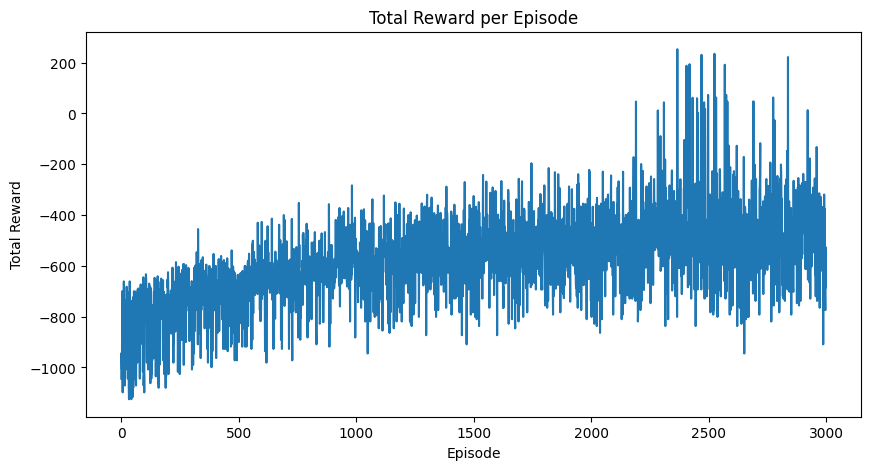

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

In [ ]:
solutions

[]

In [ ]:
final_grids = {}
for pair in PAIRS:
    #pair = ((2,5), (8,4))
    route_grid = generate_route(pair, target_net)
    final_grids[pair] = route_grid

## [*] Model Load
-------

In [ ]:
def load_model_info(model_name="ver_1"):

    file_path = f"./models/model_{model_name}.pth"

    if not os.path.exists(file_path):
        print("FATAL ERROR : model path not exist")
    model_info = torch.load(file_path)
    print(f"model_loaded : model_{model_name}")

    model = DQN()
    model.load_state_dict(model_info['model_state_dict'])
    model.to(device)
    model.eval()

    reward_list = model_info.get('rewards', [])
    step_list = model_info.get('steps', [])

    return model, reward_list, step_list